In [26]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import resnet50
import torch.nn.functional as F

In [27]:
# Lokasi dataset
data_dir = './dataset/Fruits_Vegetables_Dataset'

In [28]:
# Transformasi untuk data augmentasi dan normalisasi
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Memuat dataset dengan transformasi
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [29]:
# Menentukan ukuran split: 70% train, 15% validation, 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Membagi dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [30]:
# DataLoader untuk tiap subset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 4197, Validation size: 899, Test size: 901


Ukuran batch: torch.Size([32, 3, 224, 224])


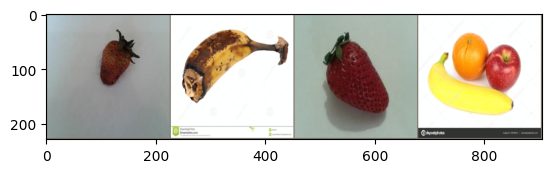

Labels: tensor([9, 6, 4, 1])


In [31]:
import torchvision

# Fungsi untuk menampilkan gambar dengan unnormalization
def imshow(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img.numpy().transpose((1, 2, 0))  # Pindahkan channel ke format HxWxC
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Batasi nilai ke dalam rentang [0, 1]
    plt.imshow(img)
    plt.show()

# Ambil satu batch dari train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Periksa ukuran batch
print(f"Ukuran batch: {images.size()}")  # Seharusnya (batch_size, 3, 224, 224)

# Menampilkan beberapa gambar dengan augmentasi
imshow(torchvision.utils.make_grid(images[:4]))  # Menampilkan 4 gambar pertama dalam batch
print('Labels:', labels[:4])  # Label pertama dari batch


In [32]:
# Tentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
# Mengimpor model ResNet dan mengubah lapisan akhir
model = models.resnet50(pretrained=True)  # Menggunakan ResNet18 sebagai contoh
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # Mengubah lapisan akhir menjadi jumlah kelas (10)
model = model.to(device)

d:\01 KULIAH\SEMESTER 5\APLIKASI WEB\Streamlit\global\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# Tentukan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
epochs = 5
train_losses, val_losses = [], []

Epoch 1/5: 100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [1/5], Train Loss: 0.8030, Train Accuracy: 74.62%, Val Loss: 1.0098, Validation Accuracy: 67.63%


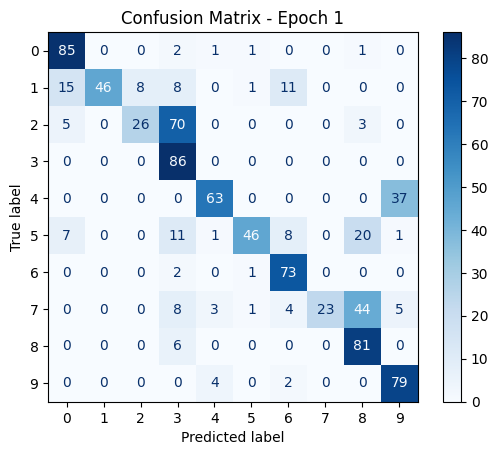

Epoch 2/5: 100%|██████████| 132/132 [00:31<00:00,  4.14it/s]


Epoch [2/5], Train Loss: 0.4150, Train Accuracy: 87.30%, Val Loss: 0.3029, Validation Accuracy: 90.66%


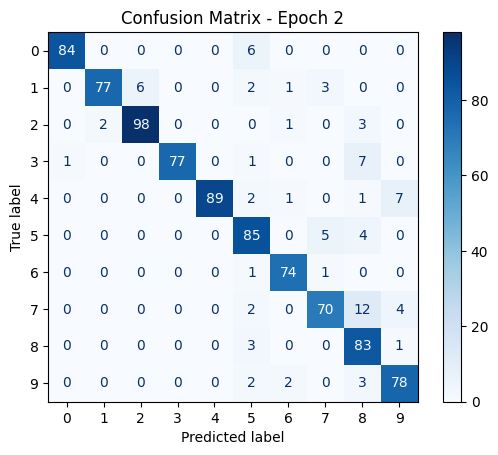

Epoch 3/5: 100%|██████████| 132/132 [00:32<00:00,  4.12it/s]


Epoch [3/5], Train Loss: 0.3108, Train Accuracy: 90.71%, Val Loss: 0.4428, Validation Accuracy: 85.43%


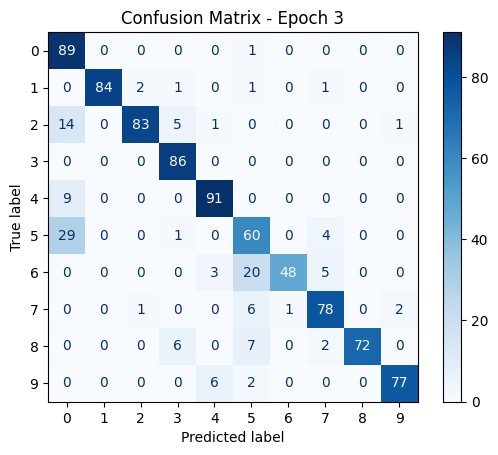

Epoch 4/5: 100%|██████████| 132/132 [00:32<00:00,  4.12it/s]


Epoch [4/5], Train Loss: 0.2560, Train Accuracy: 92.18%, Val Loss: 0.1964, Validation Accuracy: 93.88%


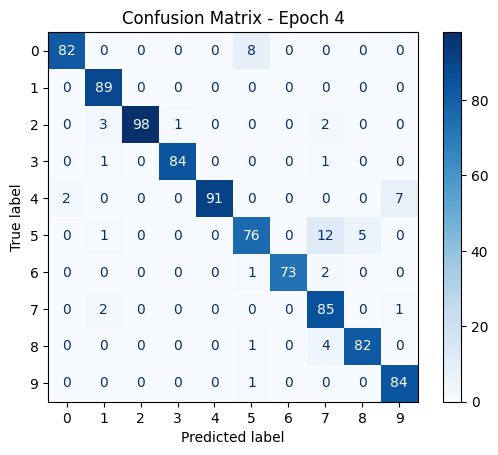

Epoch 5/5: 100%|██████████| 132/132 [00:32<00:00,  4.12it/s]


Epoch [5/5], Train Loss: 0.1845, Train Accuracy: 94.02%, Val Loss: 0.2360, Validation Accuracy: 92.88%


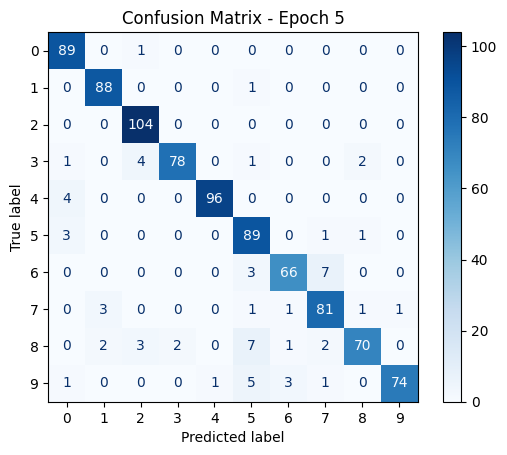

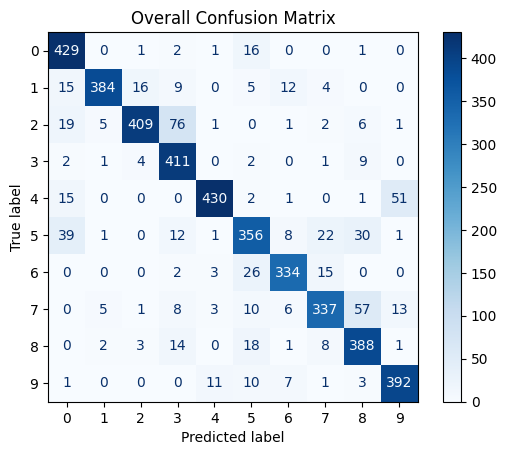

Training selesai.


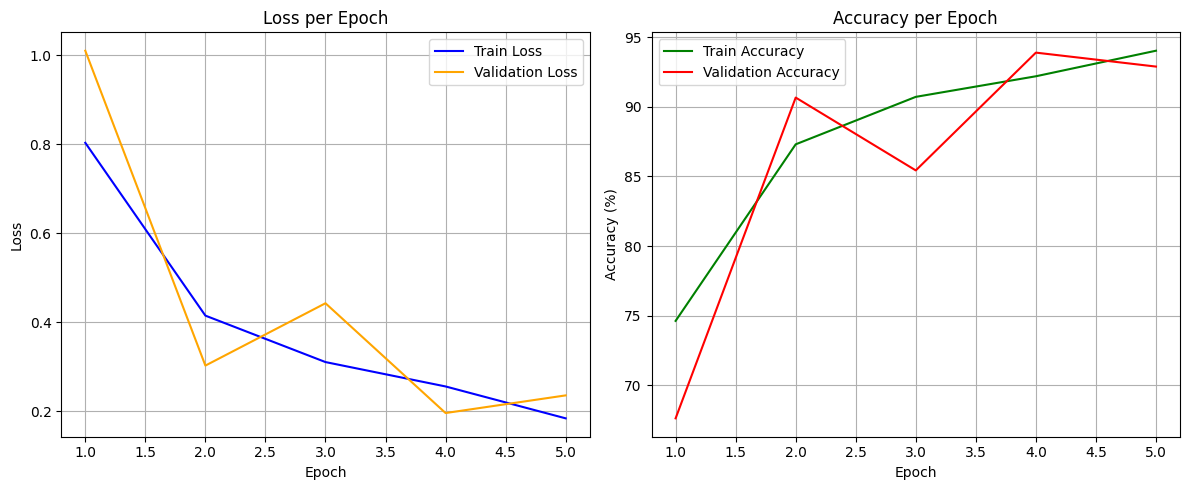

In [35]:
# Misalkan Anda telah mendefinisikan model, criterion, optimizer, train_loader, val_loader sebelumnya
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Menyimpan semua prediksi dan label untuk confusion matrix keseluruhan
all_val_predictions = []
all_val_labels = []

# Loop pelatihan
for epoch in range(epochs):
    model.train()  # Set model ke mode training
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward dan optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Hitung akurasi
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Hitung rata-rata loss dan akurasi untuk epoch ini
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluasi di data validasi
    model.eval()  # Set model ke mode evaluasi
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Menyimpan prediksi dan label untuk confusion matrix
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Hitung akurasi
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_predictions.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Simpan prediksi dan label untuk keseluruhan confusion matrix
    all_val_predictions.extend(val_predictions)
    all_val_labels.extend(val_labels)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

    # Hitung dan tampilkan confusion matrix per epoch
    conf_matrix = confusion_matrix(val_labels, val_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
    plt.show()

# Hitung dan tampilkan confusion matrix keseluruhan setelah semua epoch
overall_conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)
overall_disp = ConfusionMatrixDisplay(confusion_matrix=overall_conf_matrix)
overall_disp.plot(cmap=plt.cm.Blues)
plt.title('Overall Confusion Matrix')
plt.show()

print("Training selesai.")

# Buat DataFrame untuk log performa
performance_log = {
    'Epoch': range(1, epochs + 1),
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies
}

performance_df = pd.DataFrame(performance_log)

# Visualisasi Performace Log
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(performance_df['Epoch'], performance_df['Train Loss'], label='Train Loss', color='blue')
plt.plot(performance_df['Epoch'], performance_df['Validation Loss'], label='Validation Loss', color='orange')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(performance_df['Epoch'], performance_df['Train Accuracy'], label='Train Accuracy', color='green')
plt.plot(performance_df['Epoch'], performance_df['Validation Accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

# Tampilkan plot
plt.tight_layout()
plt.show()


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14    

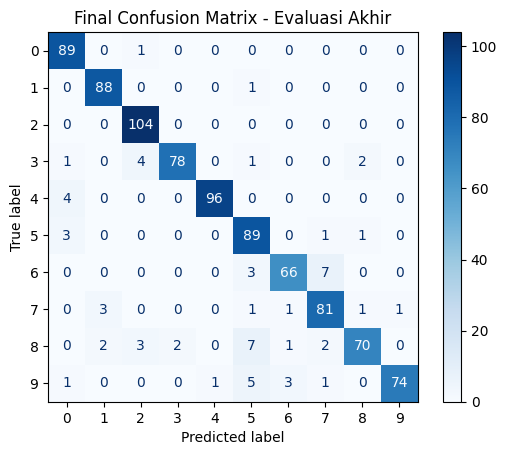

In [36]:
# Pastikan model sudah ada di mode evaluasi
model.eval()

# Jika ingin mencetak summary model (gunakan torchsummary)
# Pastikan input size sesuai dengan ukuran gambar pada dataset
try:
    print("Model Summary:")
    summary(model, input_size=(3, 224, 224))  # Sesuaikan (3, 224, 224) jika ukuran input berbeda
except Exception as e:
    print(f"Error saat mencetak summary model: {e}")

# Evaluasi model di data validasi
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Prediksi kelas
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Menghitung metrik evaluasi
print("Evaluasi Akhir Model:")
print(classification_report(all_labels, all_predictions))
print(f"Akurasi Keseluruhan: {accuracy_score(all_labels, all_predictions) * 100:.2f}%")

# Confusion Matrix untuk evaluasi akhir
final_conf_matrix = confusion_matrix(all_labels, all_predictions)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix)
final_disp.plot(cmap=plt.cm.Blues)
plt.title('Final Confusion Matrix - Evaluasi Akhir')
plt.show()


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14    

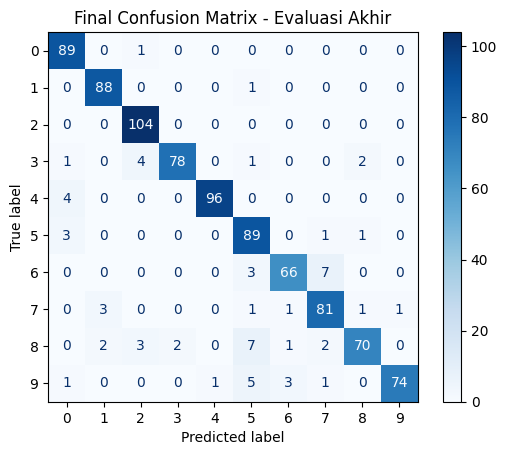

In [37]:
# Pastikan model sudah ada di mode evaluasi
model.eval()

# Jika ingin mencetak summary model (gunakan torchsummary)
# Pastikan input size sesuai dengan ukuran gambar pada dataset
try:
    print("Model Summary:")
    summary(model, input_size=(3, 224, 224))  # Sesuaikan (3, 224, 224) jika ukuran input berbeda
except Exception as e:
    print(f"Error saat mencetak summary model: {e}")

# Evaluasi model di data validasi
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Prediksi kelas
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Menghitung metrik evaluasi
print("Evaluasi Akhir Model:")
print(classification_report(all_labels, all_predictions))
print(f"Akurasi Keseluruhan: {accuracy_score(all_labels, all_predictions) * 100:.2f}%")

# Confusion Matrix untuk evaluasi akhir
final_conf_matrix = confusion_matrix(all_labels, all_predictions)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_conf_matrix)
final_disp.plot(cmap=plt.cm.Blues)
plt.title('Final Confusion Matrix - Evaluasi Akhir')
plt.show()


In [38]:
# Menyimpan model yang telah dilatih
model_path = 'trained_fruit_quality_modelv5.pth'
torch.save(model.state_dict(), model_path)
print(f"Model berhasil disimpan ke '{model_path}'")

Model berhasil disimpan ke 'trained_fruit_quality_modelv5.pth'


C:\Users\Naoval\AppData\Local\Temp\ipykernel_34956\1873727818.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_fruit_quality_mod

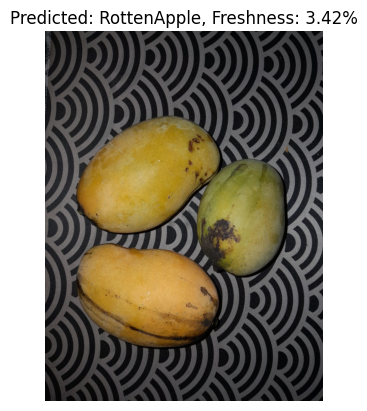

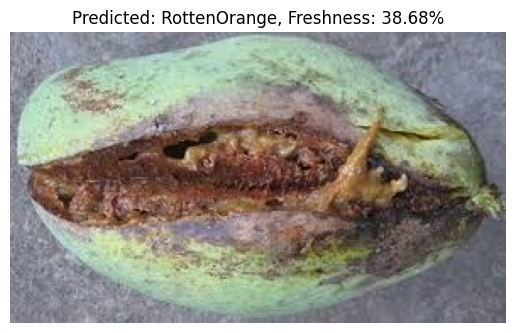

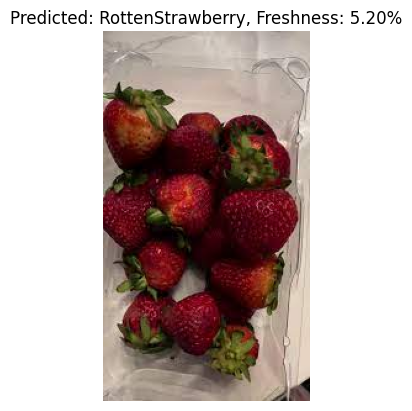

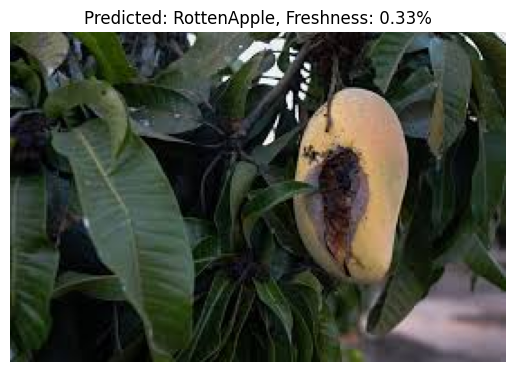

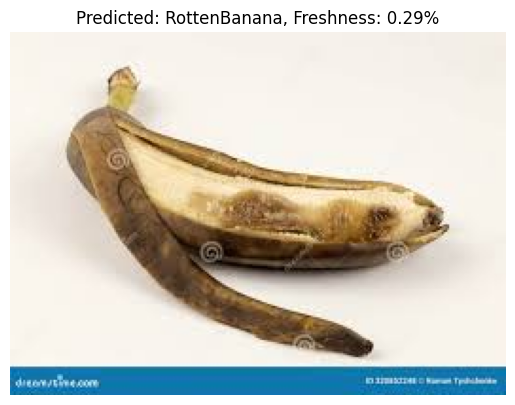

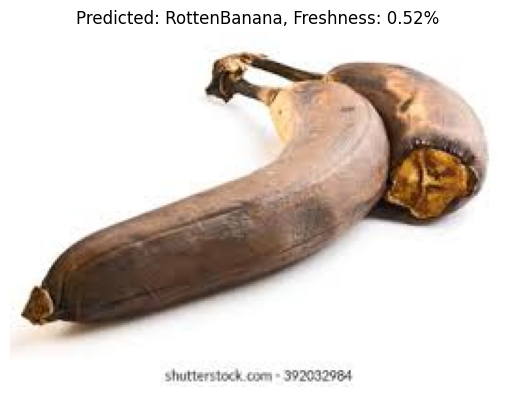

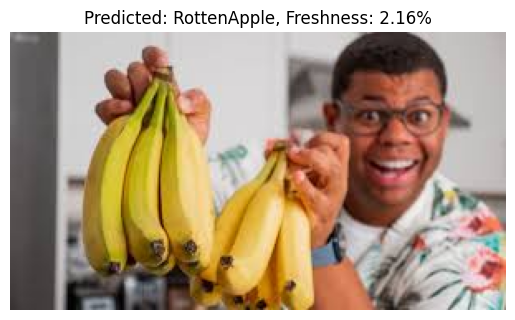

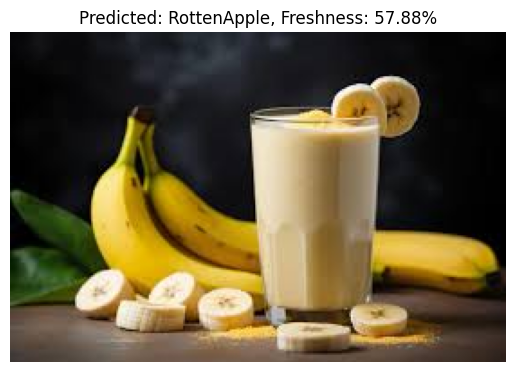

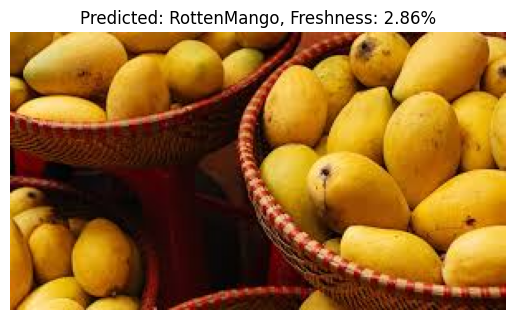

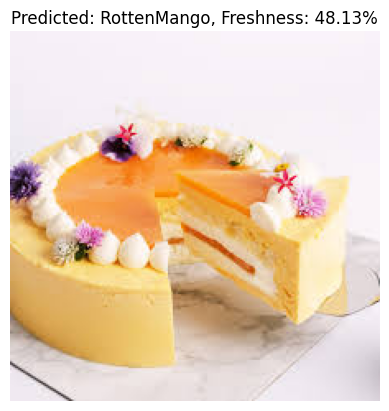

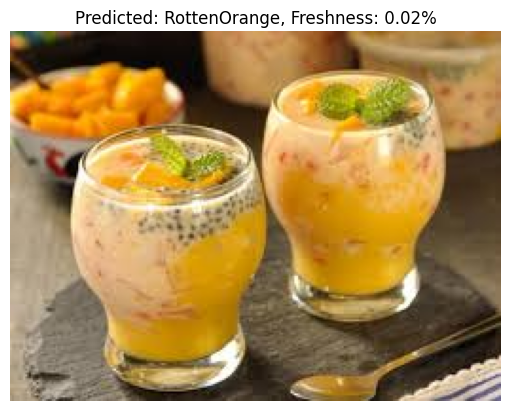

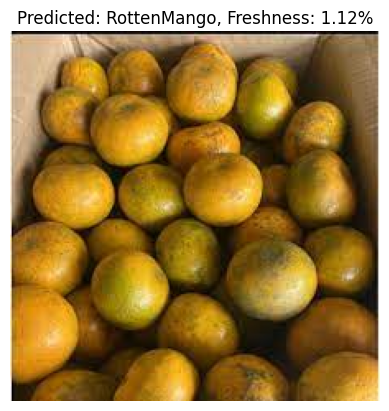

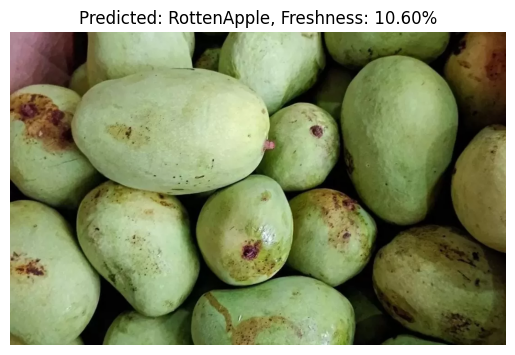

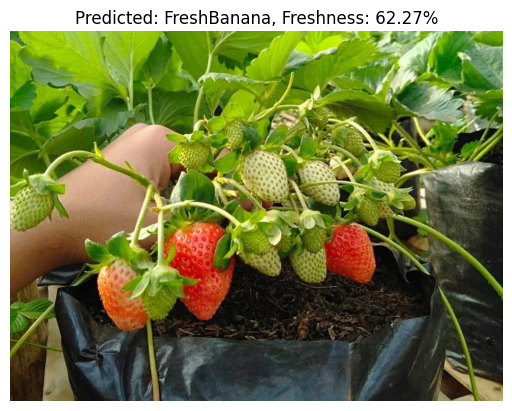

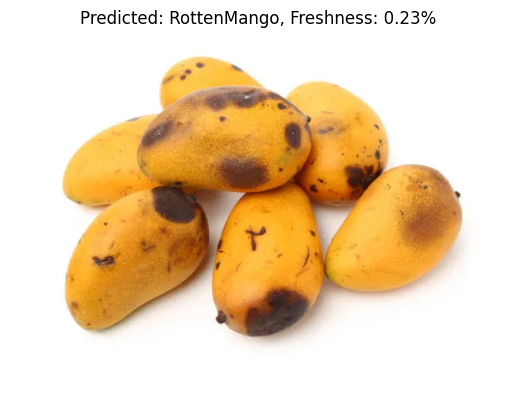

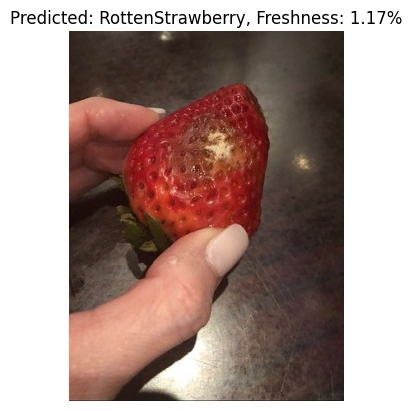

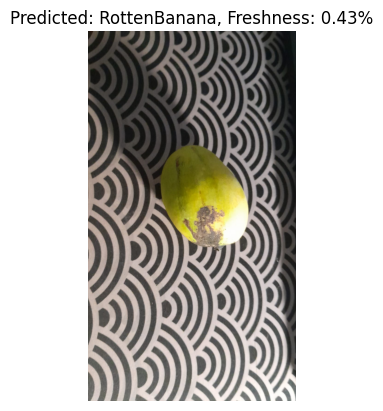

Hasil Prediksi dengan Tingkat Kesegaran:
ee76aec2-7c65-4a80-a971-f58aa2b27b6d.jpg: Kelas - RottenApple, Kesegaran - 3.42%
images (1).jpg: Kelas - RottenOrange, Kesegaran - 38.68%
images (10).jpg: Kelas - RottenStrawberry, Kesegaran - 5.20%
images (2).jpg: Kelas - RottenApple, Kesegaran - 0.33%
images (3).jpg: Kelas - RottenBanana, Kesegaran - 0.29%
images (4).jpg: Kelas - RottenBanana, Kesegaran - 0.52%
images (5).jpg: Kelas - RottenApple, Kesegaran - 2.16%
images (6).jpg: Kelas - RottenApple, Kesegaran - 57.88%
images (7).jpg: Kelas - RottenMango, Kesegaran - 2.86%
images (8).jpg: Kelas - RottenMango, Kesegaran - 48.13%
images (9).jpg: Kelas - RottenOrange, Kesegaran - 0.02%
images.jpg: Kelas - RottenMango, Kesegaran - 1.12%
Manfaat-mangga-95867837.jpg: Kelas - RottenApple, Kesegaran - 10.60%
photo_2022-03-15-12.05.07.jpeg: Kelas - FreshBanana, Kesegaran - 62.27%
rot-mango-fruit.jpg: Kelas - RottenMango, Kesegaran - 0.23%
rotten-strawberry-served.jpg: Kelas - RottenStrawberry, Kesegar

In [41]:
from PIL import Image

# Definisikan ulang model sesuai dengan model saat training
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Output layer sesuai dengan 10 kelas
model.load_state_dict(torch.load("trained_fruit_quality_model.pth"))
model = model.to(device)
model.eval()

# Daftar kelas
class_labels = ['FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry', 
                'RottenApple', 'RottenBanana', 'RottenMango', 'RottenOrange', 'RottenStrawberry']

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)  # Tambahkan dimensi batch
    return image

# Fungsi prediksi dengan tingkat kesegaran dalam bentuk persentase
def predict_image_with_freshness(image_path):
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)  # Dapatkan probabilitas untuk setiap kelas
        _, predicted = torch.max(outputs, 1)
        
        # Jika kelasnya adalah "Fresh", gunakan probabilitas sebagai tingkat kesegaran
        label = class_labels[predicted.item()]
        if "Fresh" in label:
            freshness_percentage = probabilities[0, predicted.item()].item() * 100
        else:
            # Jika kelasnya "Rotten", gunakan kebalikan dari probabilitas
            freshness_percentage = (1 - probabilities[0, predicted.item()].item()) * 100

    return label, freshness_percentage

# Fungsi untuk prediksi semua gambar dalam folder dengan tingkat kesegaran
def predict_folder_with_freshness(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    predictions = {}

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        label, freshness = predict_image_with_freshness(image_path)
        predictions[image_file] = {"Class": label, "Freshness": f"{freshness:.2f}%"}

        # Tampilkan gambar dengan prediksi
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(f"Predicted: {label}, Freshness: {freshness:.2f}%")
        plt.axis('off')
        plt.show()

    return predictions

# Contoh penggunaan
folder_path = "./dataset/predict" 
all_predictions = predict_folder_with_freshness(folder_path)
print("Hasil Prediksi dengan Tingkat Kesegaran:")
for img_name, info in all_predictions.items():
    print(f"{img_name}: Kelas - {info['Class']}, Kesegaran - {info['Freshness']}")
